# WFI2033 1/f Row-Median Correction

Workflow:
1. 从 `jw01198-o004_t004_nircam_clear-f115w_i2d.fits` 切 `300x300`。
2. 在该 cutout 左侧取 `10x300` 条带，对每一行取 median（仅用于估计该行偏置）。
3. 仅对 `SCI`：把这个行偏置从该行整行（300 列）都减掉。
4. `ERR/noise` 不做校正，只做同位置裁剪。
5. 从校正后的 `300x300 SCI` 中心再裁 `150x150`。
6. 保存 raw/corrected 的 FITS（包含 `SCI` 和 `ERR`）。



In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from astropy.io import fits


In [2]:
DATA_DIR = "../Data/WFI2033"
raw_path = os.path.join(DATA_DIR, "jw01198-o004_t004_nircam_clear-f115w_i2d.fits")

# lens center in the full image (0-based pixel coordinates)
x_center = 6985
y_center = 3594

size_300 = 300
size_150 = 150
left_width = 10

out_300_raw = os.path.join(DATA_DIR, f"jw01198-o004_t004_nircam_clear-f115w_i2d_cut_x{x_center}_y{y_center}_300_raw.fits")
out_300_corr = os.path.join(DATA_DIR, f"jw01198-o004_t004_nircam_clear-f115w_i2d_cut_x{x_center}_y{y_center}_300_rowmedcorr.fits")
out_150_corr = os.path.join(DATA_DIR, f"jw01198-o004_t004_nircam_clear-f115w_i2d_cut_x{x_center}_y{y_center}_150_rowmedcorr.fits")


In [3]:
def cutout_2d(arr, xc, yc, size):
    half = size // 2
    x0 = int(round(xc)) - half
    y0 = int(round(yc)) - half
    x1 = x0 + size
    y1 = y0 + size
    if x0 < 0 or y0 < 0 or x1 > arr.shape[1] or y1 > arr.shape[0]:
        raise ValueError(f"Requested cutout is out of bounds: x[{x0}:{x1}] y[{y0}:{y1}] for shape {arr.shape}")
    return arr[y0:y1, x0:x1].copy(), (x0, x1, y0, y1)

with fits.open(raw_path, memmap=True) as hdul:
    primary_hdr = hdul[0].header.copy()
    sci_full = np.array(hdul["SCI"].data, dtype=np.float64)
    err_full = np.array(hdul["ERR"].data, dtype=np.float64)
    sci_hdr = hdul["SCI"].header.copy()
    err_hdr = hdul["ERR"].header.copy()

sci_300_raw, bbox_300 = cutout_2d(sci_full, x_center, y_center, size_300)
err_300, _ = cutout_2d(err_full, x_center, y_center, size_300)

print("bbox_300 (x0, x1, y0, y1):", bbox_300)
print("sci_300_raw shape:", sci_300_raw.shape)
print("err_300 shape:", err_300.shape)


bbox_300 (x0, x1, y0, y1): (6835, 7135, 3444, 3744)
sci_300_raw shape: (300, 300)
err_300 shape: (300, 300)


In [4]:
# 1) use only the left strip (10 columns) to estimate row-wise bias
left_strip = sci_300_raw[:, :left_width]          # shape = (300, 10)
row_bias = np.nanmedian(left_strip, axis=1)       # shape = (300,)

# backward-compatible alias
row_median = row_bias

# 2) subtract that bias from the FULL corresponding row of the 300x300 SCI cutout
#    (i.e., all 300 columns are corrected, not only the left strip)
sci_300_corr = sci_300_raw - row_bias[:, None]    # shape = (300, 300)

# ERR/noise is NOT corrected, only passed through (and later cropped)
err_300_corr = err_300.copy()

# then center-crop to 150x150
start = (size_300 - size_150) // 2
end = start + size_150
sci_150_corr = sci_300_corr[start:end, start:end].copy()
err_150 = err_300_corr[start:end, start:end].copy()

# explicit guards
assert np.allclose(err_300_corr, err_300, equal_nan=True)

# verify row-wise full-row subtraction on SCI: every column in a row shifted by same row_bias
check_idx = [0, size_300 // 2, size_300 - 1]
for ridx in check_idx:
    delta = sci_300_raw[ridx, :] - sci_300_corr[ridx, :]
    assert np.allclose(delta, row_bias[ridx], equal_nan=True)

print("left_strip shape:", left_strip.shape)
print("row_bias shape:", row_bias.shape)
print("sci_300_corr shape:", sci_300_corr.shape)
print("sci_150_corr shape:", sci_150_corr.shape)
print("err_300_corr unchanged:", np.allclose(err_300_corr, err_300, equal_nan=True))
print("full-row SCI subtraction check: PASS")


left_strip shape: (300, 10)
row_bias shape: (300,)
sci_300_corr shape: (300, 300)
sci_150_corr shape: (150, 150)
err_300_corr unchanged: True
full-row SCI subtraction check: PASS


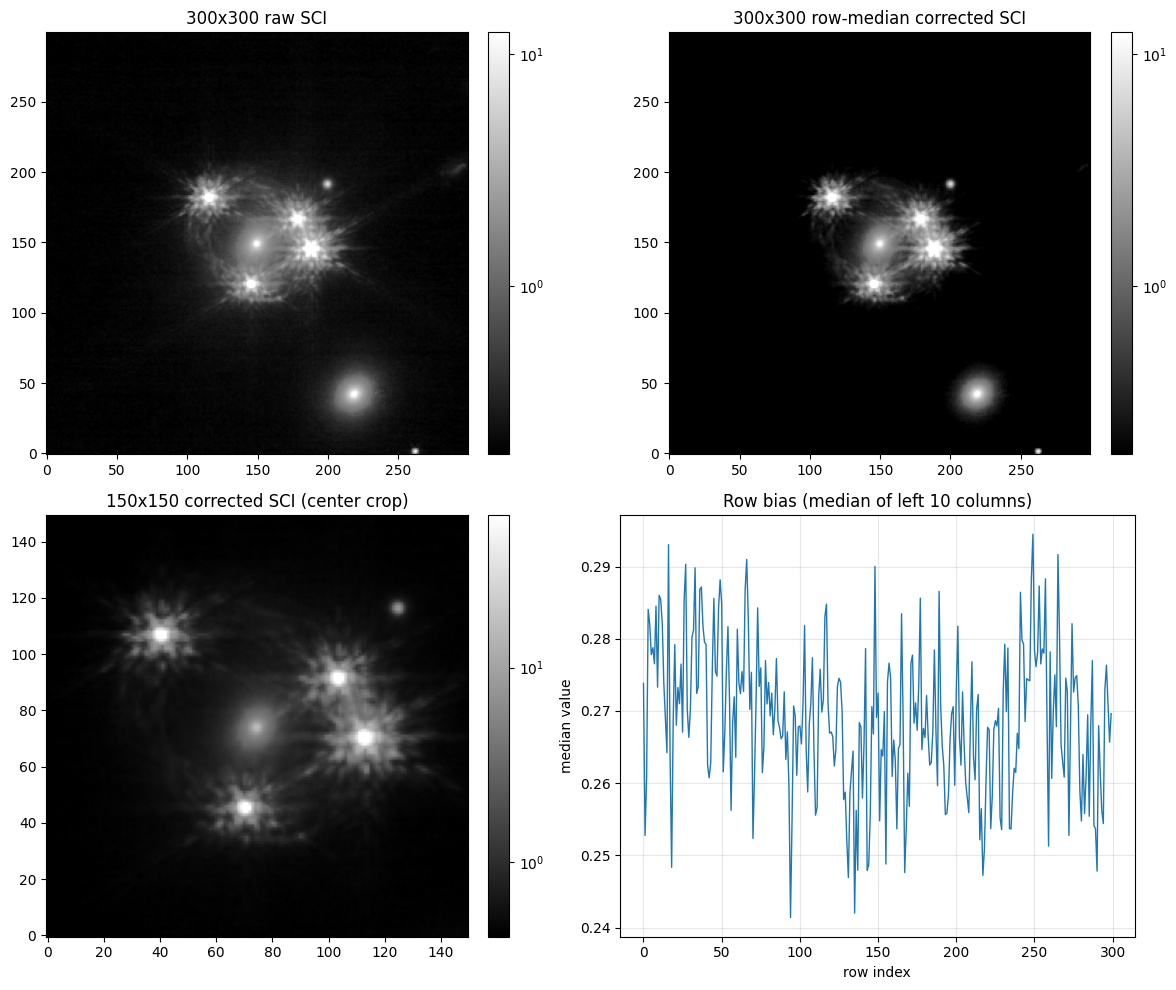

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

norm300 = colors.SymLogNorm(
    linthresh=max(np.nanstd(sci_300_raw) * 0.1, 1e-3),
    vmin=np.nanpercentile(sci_300_raw, 5),
    vmax=np.nanpercentile(sci_300_raw, 99.8),
)
norm150 = colors.SymLogNorm(
    linthresh=max(np.nanstd(sci_150_corr) * 0.1, 1e-3),
    vmin=np.nanpercentile(sci_150_corr, 5),
    vmax=np.nanpercentile(sci_150_corr, 99.8),
)

im0 = axes[0, 0].imshow(sci_300_raw, origin="lower", cmap="gray", norm=norm300)
axes[0, 0].set_title("300x300 raw SCI")
plt.colorbar(im0, ax=axes[0, 0], fraction=0.046, pad=0.04)

im1 = axes[0, 1].imshow(sci_300_corr, origin="lower", cmap="gray", norm=norm300)
axes[0, 1].set_title("300x300 row-median corrected SCI")
plt.colorbar(im1, ax=axes[0, 1], fraction=0.046, pad=0.04)

im2 = axes[1, 0].imshow(sci_150_corr, origin="lower", cmap="gray", norm=norm150)
axes[1, 0].set_title("150x150 corrected SCI (center crop)")
plt.colorbar(im2, ax=axes[1, 0], fraction=0.046, pad=0.04)

axes[1, 1].plot(row_bias, lw=1.0)
axes[1, 1].set_title("Row bias (median of left 10 columns)")
axes[1, 1].set_xlabel("row index")
axes[1, 1].set_ylabel("median value")
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [6]:
def write_sci_err_fits(path, sci, err, primary_header, sci_header, err_header, extra_hdus=None):
    phdr = primary_header.copy()
    phdr["COMMENT"] = "Generated by WFI2033_1f_row_median_correction.ipynb"

    shdr = sci_header.copy()
    ehdr = err_header.copy()

    hdu_list = [
        fits.PrimaryHDU(header=phdr),
        fits.ImageHDU(data=sci.astype(np.float32), header=shdr, name="SCI"),
        fits.ImageHDU(data=err.astype(np.float32), header=ehdr, name="ERR"),
    ]
    if extra_hdus is not None:
        hdu_list.extend(extra_hdus)

    fits.HDUList(hdu_list).writeto(path, overwrite=True)

write_sci_err_fits(
    out_300_raw,
    sci_300_raw,
    err_300,
    primary_hdr,
    sci_hdr,
    err_hdr,
)

write_sci_err_fits(
    out_300_corr,
    sci_300_corr,
    err_300_corr,
    primary_hdr,
    sci_hdr,
    err_hdr,
    extra_hdus=[fits.ImageHDU(data=row_bias.astype(np.float32), name="ROW_MEDIAN_LEFT10")],
)

write_sci_err_fits(
    out_150_corr,
    sci_150_corr,
    err_150,
    primary_hdr,
    sci_hdr,
    err_hdr,
)

print("saved:", out_300_raw)
print("saved:", out_300_corr)
print("saved:", out_150_corr)



saved: ../Data/WFI2033/jw01198-o004_t004_nircam_clear-f115w_i2d_cut_x6985_y3594_300_raw.fits
saved: ../Data/WFI2033/jw01198-o004_t004_nircam_clear-f115w_i2d_cut_x6985_y3594_300_rowmedcorr.fits
saved: ../Data/WFI2033/jw01198-o004_t004_nircam_clear-f115w_i2d_cut_x6985_y3594_150_rowmedcorr.fits
